In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import punkt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from src.functions import get_sents, display_topics
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Read in the transcripts
raw_data_path = './data/raw/ted-talks/'
transcripts_filename = 'transcripts.csv'
t_df = pd.read_csv(raw_data_path+transcripts_filename)
# Pare down the corpus to only those talks with the word 'love'
love=t_df[t_df['transcript'].str.contains(r'\blove',case=False)]
# Tokenize
# Get the collection of n(=5)-sentence snippets with the word 'love'
love_snippets = get_sents(love,'love',0,0)

From results EDA I found that talk ID=132 and 2382 were 'outliers' after dimension reduction was performed when using CountVectorizer(binary=False).  These two talks were songs that mentioned love a lot.  By deleting them I'm trying to capture orthogonal variance in topics modeling to not be dominated by these 2 talks.

In [3]:
love_snippets.loc[[132, 2382]]

,transcript,url,n_love_sents,love
132,I’d like to dedicate this one to all the women...,https://www.ted.com/talks/vusi_mahlasela_sings...,12.0,"♫ ♫ Should I now stop singing of love, ♫ ♫ now..."
2382,(Sings) Water Boy(Guitar strum)where are you h...,https://www.ted.com/talks/rhiannon_giddens_3_s...,14.0,So I wrote a song based on some of those narra...


I'll uncomment this when I want those song talks eliminated.

In [4]:
# love_snippets.drop(labels=[132, 2382],inplace=True)

In [5]:
# Topic modeling
# Vectorize
cv1 = CountVectorizer(stop_words='english',binary=True)
cv_doc_word = cv1.fit_transform(love_snippets.love)
# Dimension Reduction
cv_lsa=[]
cv_doc_topic=[]
for i in range(2,6):
    cv_lsa.append(TruncatedSVD(i))
    cv_doc_topic.append(cv_lsa[i-2].fit_transform(cv_doc_word))
    print(int(i),'topics variance ratios:',cv_lsa[i-2].explained_variance_ratio_)

2 topics variance ratios: [0.02513815 0.01428794]
3 topics variance ratios: [0.02513815 0.01430466 0.01220083]
4 topics variance ratios: [0.02513816 0.01431339 0.01218962 0.01083878]
5 topics variance ratios: [0.02513815 0.01430509 0.01218056 0.01081614 0.01020274]


In [6]:
display_topics(cv_lsa[0], cv1.get_feature_names(), 14)


Topic  0
love, loved, people, like, just, know, think, really, time, ve, laughter, life, world, way

Topic  1
person, feel, loved, say, got, end, long, years, time, thank, life, want, wanted, way


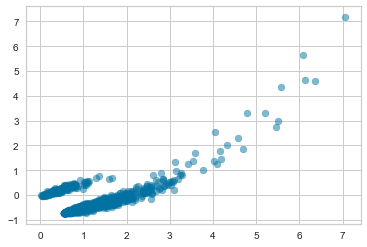

In [7]:
plt.scatter(cv_doc_topic[0][:,0],cv_doc_topic[0][:,1], alpha = 0.5);
# plt.axis([0, 60, -30, 10])

Investigating the interesting result above seemed  to show that the points in the upper right had longer snippets.  So, I decided to see if there was a relationship with the number of sentences with love in it:

Matplotlib colormaps: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

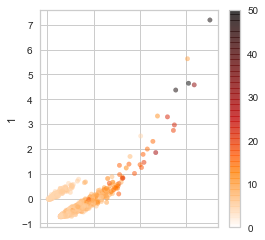

In [8]:
df=pd.DataFrame(cv_doc_topic[0])
df.plot.scatter(x=0,y=1,figsize=(4,4), alpha=0.5,\
               c=love_snippets.n_love_sents+3, cmap=plt.get_cmap('gist_heat_r'),vmin=0);

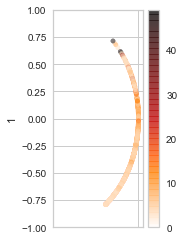

In [9]:
df = pd.DataFrame(normalize(cv_doc_topic[0]))
df.plot.scatter(x=0,y=1,figsize=(2,4), alpha=0.5,\
               c=love_snippets.n_love_sents+2, cmap=plt.get_cmap('gist_heat_r'),vmin=0)
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

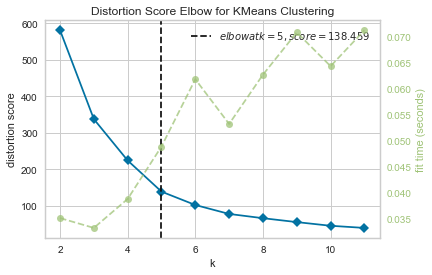

In [10]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(cv_doc_topic[0])        # Fit the data to the visualizer
visualizer.show();        # Finalize and render the figure

In [11]:
visualizer.elbow_value_

5

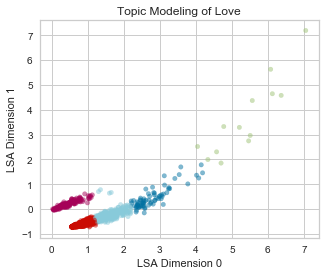

In [12]:
df=pd.DataFrame(cv_doc_topic[0],columns=['LSA Dimension 0','LSA Dimension 1'])
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=None,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x='LSA Dimension 0',y='LSA Dimension 1',\
                figsize=(5,4), c=col, alpha = 0.5,title='Topic Modeling of Love');
# plt.axis([-1,1.05,-1,1]);

In [13]:
for i,center in enumerate(km.cluster_centers_):
    print(cmap[i],center)

r [ 0.85020363 -0.5948375 ]
g [5.37051471 3.64778316]
b [2.79130625 0.46698173]
c [ 1.57413898 -0.25171813]
m [0.42972103 0.19168386]


Getting the matrix of euclidean distances from the cluster centers: (used to work that out)

In [14]:
pd.DataFrame(pairwise_distances(km.cluster_centers_,cv_doc_topic[0]).T).head()

,0,1,2,3,4
0,0.453742,5.769735,1.759890,0.347398,1.021546
1,0.208826,6.004213,2.004954,0.592602,0.934895
2,0.194360,6.392280,2.405482,0.992847,0.938141
3,0.957948,5.292935,1.256710,0.156967,1.335001
4,2.775557,3.546013,0.567996,1.978801,2.881269


Show the snippets from the 4 (euclidean distance) closest documents:

In [15]:
doc_topic = cv_doc_topic[0]
euclidean_distances_to_centers=pd.DataFrame(pairwise_distances(km.cluster_centers_,doc_topic).T)
for i,center in enumerate(km.cluster_centers_):
    n_closest=euclidean_distances_to_centers[i].nsmallest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,cs in n_closest.iteritems():
#         print(j,cs)
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.85020363 -0.5948375 ] color= r
8 : [ 0.8484843  -0.59854944] And so again, we had a whole variety of ideas that came in.This one I personally love, because the idea is that architecture is not just about solutions, but about raising awareness. This one I love.
420 : [ 0.85636822 -0.59667339] But you know I'd love to be able to tell you that Umar is a typical kid with polio these days, but it's not true.
208 : [ 0.85774872 -0.59792936] In this case misery truly does love company.Now think about the following: if China and India were as rich as the United States is today, the market for cancer drugs would be eight times larger than it is now.
946 : [ 0.85994113 -0.59769829] But I said, "It's still not publishable, because I love what you did with the mumbo jumbo, with the machine learning, but it's not really standard-of-proof evidence that we have."


Cluster centered at: [5.37051471 3.64778316] color= g
138 : [5.20911688 3.29124979] But when I try and think abo

I'll now project the doc_topic values onto the unit circle, sphere, hypersphere I.  If I don't re-cluster yet, I'm looking at the clustering results from above:

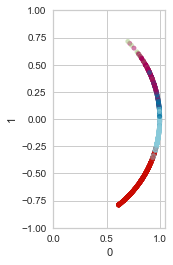

In [16]:
df = pd.DataFrame(normalize(doc_topic))
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

This next cell identifies the documents closest to the cluster centers using cosine similarity.

In [17]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=doc_topic).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',doc_topic[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.85020363 -0.5948375 ] color= r
273 : [ 0.81653259 -0.56970054] If you gave me only one wish for the next 50 years — I could pick who's president, I could pick a vaccine, which is something I love, or I could pick that this thing that's half the cost with no CO2 gets invented — this is the wish I would pick.
430 : [ 0.90248386 -0.62965118] In the rest of my talk, I'd like to tell you about how I learned to stop worrying and love the challenge posed by the Indus script.
208 : [ 0.85774872 -0.59792936] In this case misery truly does love company.Now think about the following: if China and India were as rich as the United States is today, the market for cancer drugs would be eight times larger than it is now.
420 : [ 0.85636822 -0.59667339] But you know I'd love to be able to tell you that Umar is a typical kid with polio these days, but it's not true.


Cluster centered at: [5.37051471 3.64778316] color= g
445 : [0.26276397 0.17769987] Our self-deception becomes a

Now clustering on the 

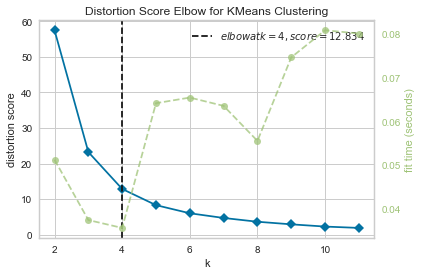

In [18]:
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)        # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

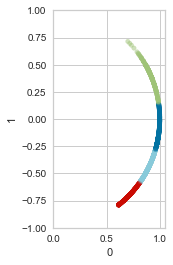

In [19]:
df = pd.DataFrame(normalize(doc_topic))
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
km.labels_
cmap = {0:'r',1:'g',2:'b',3:'c',4:'m',5:'y',6:'orange',7:'k',8:'aqua',9:'yellow'}
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)
df.plot.scatter(x=0,y=1,figsize=(2,4), c=col, alpha = 0.5);
plt.axis([0,1.05,-1,1]);
# plt.savefig("reports/figures/figure_1.png")

In [20]:
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.70841856 -0.70052276] color= r
145 : [ 0.71090807 -0.70328495] I love her, you know.
945 : [ 0.71077658 -0.70341783] That is the moment I love and that is the moment I love to share with others.So at this point, my curiosity grew.
388 : [ 0.71149158 -0.70269462] (Laughter) But basically I love being a woman.
707 : [ 0.71151645 -0.70266944] We've also learned the penguins love robots.


Cluster centered at: [0.91271419 0.38762559] color= g
531 : [0.92097798 0.38961464] And he takes the relatives by the hand, and guides them each to their loved ones amid the wreckage.What Simonides figured out at that moment, is something that I think we all kind of intuitively know, which is that, as bad as we are at remembering names and phone numbers, and word-for-word instructions from our colleagues, we have really exceptional visual and spatial memories.
735 : [0.92109081 0.3893478 ] I think it's the loveliest thing that our brains have invented.
585 : [0.92115465 0.3891967

# The 3-topic Result

In [23]:
display_topics(cv_lsa[1], cv1.get_feature_names(), 14)


Topic  0
love, loved, people, like, just, know, think, really, time, ve, laughter, life, world, way

Topic  1
loved, feel, person, got, say, end, time, long, thank, years, life, thinking, later, wanted

Topic  2
loved, day, told, away, life, girl, old, wasn, lost, school, shadow, came, eyes, saw


In [24]:
cv_doc_topic[1]

array([[ 1.2609717 , -0.38873721,  0.295455  ],
       [ 1.04280154, -0.52596728, -0.1125232 ],
       [ 0.69277549, -0.7075228 , -0.07247713],
       ...,
       [ 0.65155066, -0.6789017 , -0.03507344],
       [ 1.04762451, -0.71017118,  0.05381469],
       [ 0.78298403, -0.67532693,  0.02368921]])

In [25]:
from mpl_toolkits.mplot3d import Axes3D

In [36]:
# Use this to visualize the un-projected doc-topic space:
# df = pd.DataFrame(cv_doc_topic[1])
# Use this to visualize the projected doc-topic space:
df = pd.DataFrame(normalize(cv_doc_topic[1]))

Helpful in getting started with 3D plotting:
* https://pythonprogramming.net/3d-graphing-pandas-matplotlib/
* https://matplotlib.org/3.1.1/gallery/mplot3d/scatter3d.html#sphx-glr-gallery-mplot3d-scatter3d-py
* https://stackoverflow.com/questions/47311632/jupyter-how-to-rotate-3d-graph

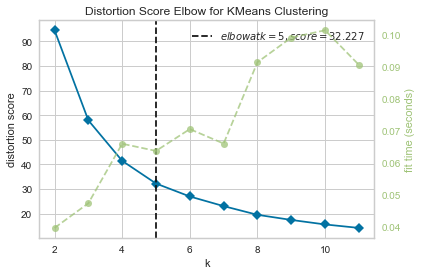

In [45]:
%matplotlib inline
km=KMeans()
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(df)                     # Fit the data to the visualizer
visualizer.show();                     # Finalize and render the figure

In [46]:
num_clusters = visualizer.elbow_value_
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=300,verbose=0) # n_init, number of times the K-mean algorithm will run
km.fit(df)
col = pd.DataFrame(np.array([km.labels_])).transpose()[0].map(cmap)

<IPython.core.display.Javascript object>


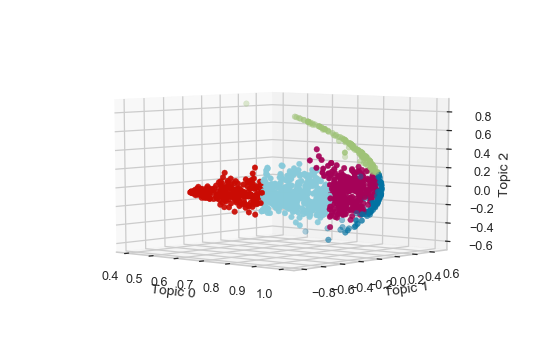

In [53]:
%matplotlib notebook
fig = plt.figure() #.gca(projection='3d')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df[0],df[1],df[2],c=col)
ax.set_xlabel('Topic 0')
ax.set_ylabel('Topic 1')
ax.set_zlabel('Topic 2');

So, what do the clusters mean?

In [52]:
doc_topic = cv_doc_topic[1]
for i,center in enumerate(km.cluster_centers_):
    n_closest=pd.DataFrame(cosine_similarity(X=[center],Y=normalize(doc_topic)).T)[0].nlargest(4)
    print('Cluster centered at:',center,'color=',cmap[i])
    for j,item in n_closest.iteritems():
        print(j,':',normalize(doc_topic)[j],love_snippets.iloc[j].love)
    print('\n')

Cluster centered at: [ 0.70811608 -0.69794321 -0.00386964] color= r
1006 : [ 0.70960267 -0.70455775 -0.00790145] And the impossibilities that had been imposed upon them by a disadvantaged community were replaced by hope and purpose.The revolution in education is happening in our schools, with adults who provide love, structure, support and knowledge.
1082 : [ 0.71338927 -0.70063759 -0.01351732] (Laughter)But he does love cupcakes.
1107 : [ 0.70570847 -0.70843308 -0.00990586] And then we did what I'm about to show you now, and I still love watching this one. Back to that lovely photo, or photo in a picture.
566 : [ 0.7011479  -0.71287101 -0.01437181] (Laughter)I'd love to share with you some images of urban beehives, because they can be anything.


Cluster centered at: [0.80167943 0.37060731 0.41715367] color= g
918 : [0.8189803  0.38364619 0.42671638] She said she loved the sound of my project, could she go to her local English-language bookshop and choose my Malaysian book and post it